# Робота №4. Вивчення структури металів за допомогою функції радіального розподілу атомів

## Мета роботи
Дослідження параметрів структури металів в кристалічному та рідкому стані за допомогою визначення ФРР атомів моделюванням методом молекулярної динаміки.

## Об'єкт дослідження
Чисті метали за умов різних температур.

## Устаткування, прилади та матеріали

In [62]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from scipy.signal import find_peaks_cwt

def read_data(name):
    data_frame = pd.read_csv(name, delimiter='\s+', skipinitialspace=True, skiprows=4,
                             names=['skip1', 'HETATM', 'type', 'X', 'Y', 'Z'])[['X', 'Y', 'Z']]
    data_frame.dropna(inplace=True)
    return data_frame

def read_rdf(name):
    data_frame = pd.read_csv(name, delimiter='\s+', skipinitialspace=True, skiprows=1,
                             names=['X', 'count', 'cummulative'], index_col='X')
    return data_frame

## Програма проведення експерименту
Створити кристал з ~1000-2000 атомів з періодичними граничними умовами. Матеріал: Pt.

In [3]:
%%writefile in.xm
read ../pot/Pt_xmd.eam

box 8 8 8

fill particle 4
1     0.0        0.0        0.0
1     0.5        0.0        0.5
1     0.5        0.5        0.0
1     0.0        0.5        0.5

fill align 8 8 8
fill orient 1 0 0  0 1 0  0 0 1
fill go

dtime $3

select all #
mass 195.084

calc T=200

clamp $1
itemp $1
scale 3.9231

select index 14571
set add 1
select keep on


cmd $4
write pdb ./out/exp_$2.pdb
WRITE file ./out/exp_$2.rdf RDF 100 2 7

Overwriting in.xm


Задаємо температуру плавлення Pt, та розрахункових температур:

In [2]:
Tmelt = 2041.4 # Kelvin
T = [round(temp, -2)for temp in [0.1*Tmelt, 1.5*Tmelt]]

Релаксовуємо матеріал при температурах 0.1 і 1.5T<sub>пл</sub>.

In [4]:
param = iter([(2e-14, 1000), (1e-14, 2000)])
for i, temp in enumerate(T):
    
    p = next(param)
    
    !xmd in.xm {temp} {i} {p[0]} {p[1]} > exp_{i}.log # temperature, n of experiment

Зчитуємо координати атомів:

In [7]:
xyz = [read_data(f'./out/exp_{i}.pdb') for i in range(2)]

## Опрацювання результатів експерименту

- Розрахувати нові координати атомів, використовуючи положення обраного атома
поблизу центру розрахункової комірки за початок координат.

In [8]:
for i in range(2):
    centre = xyz[i].iloc[1456]
    for axis in ['X', 'Y', 'Z']:
        xyz[i][axis] = xyz[i][axis] - centre[axis]
    xyz[i]['distance'] = np.sqrt(xyz[i].X ** 2 + xyz[i].Y ** 2 + xyz[i].Z **2)

Побудувати гістограму розподілу атомів за відстанню до 7 А з інтервалом 0,1 А для
температур T=0,1 і 1,5T<sub>пл</sub>, виходячи з координат атомів.

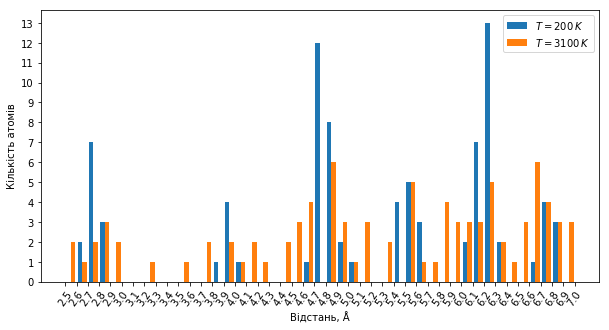

In [9]:
fig, hst = plt.subplots(figsize=(10, 5))
bins = np.arange(2.5, 7.1, 0.1)
counts, _, _ = hst.hist([xyz[i].distance[(xyz[i].distance < 7) & (xyz[i].distance > 2.5)] for i in range(2)],
                                 bins=bins, label=[f'$T = {T[i]:.0f}\,K$' for i in range(2)])

hst.legend()
hst.set_yticks(np.arange(0, np.array(counts).max()+1, 1))
hst.set_xticks(bins, minor=False)
hst.set_xticklabels(np.round(bins, 1), rotation=55)
hst.grid(False)
hst.set_xlabel('Відстань, Å')
hst.set_ylabel('Кількість атомів')

- Побудувати ФРРА за формулами

$$\rho = \frac{dn}{4\pi r^2\, dr}$$

та

$$g(r) = \frac{V}{N} \rho(r) = \frac{1}{\rho_{\textit{ат}}} \rho(r)$$

Величини $dn$ взяти з попереднього пункту, як і $dr=0.1\,A$.

In [10]:
rdf = [read_rdf(f'./out/exp_{i}.rdf') for i in range(2)]

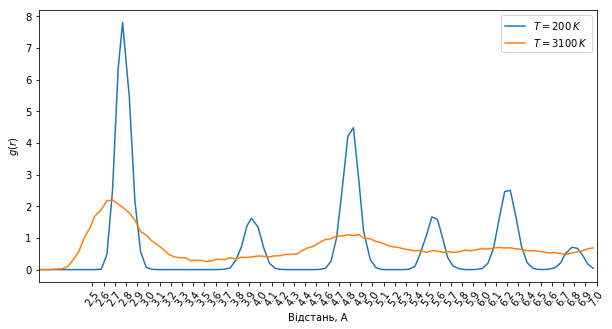

In [19]:
fig, hst = plt.subplots(figsize=(10, 5))
for i in range(2):
    rdf[i]['norm_count'] = rdf[i]['count'] / (4 * np.pi * rdf[i].index **2 * 0.1) / 50
    plt_rdf = rdf[i]['norm_count'].plot(label=f'$T = {T[i]:.0f}\,K$')

plt_rdf.legend()
plt_rdf.set_xticks(bins)
plt_rdf.set_xticklabels(np.round(bins, 1), rotation=55)
plt_rdf.set_xlabel('Відстань, А')
plt_rdf.set_ylabel("$g(r)$")

 - Знайти координаційні числа для кристалу і рідини в трьох перших координаційних сферах.

Для кристалу:

In [47]:
[s for s in [sum(arr) for arr in np.split(counts[0], indices[0])] if s != 0.0][:3]

[12.0, 6.0, 24.0]

Для рідини:

In [52]:
[s for s in [sum(arr) for arr in np.split(counts[1], indices[1])] if s != 0.0]

[10.0, 1.0, 1.0, 2.0, 6.0, 9.0, 13.0, 2.0, 47.0]

- Знайти відстані до атомів в цих сферах.

Для кристалу:

In [61]:
rdf[0].index[find_peaks_cwt(rdf[0]['norm_count'], rdf[0].index)]

Float64Index([2.77, 3.92, 4.78, 5.53, 6.18, 6.83], dtype='float64', name='X')

Для рідини:

In [63]:
rdf[1].index[find_peaks_cwt(rdf[1]['norm_count'], rdf[1].index)]

Float64Index([2.68, 3.83, 3.88, 4.73, 4.78, 6.13, 6.83, 6.88], dtype='float64', name='X')

Порівняти щільність пакування атомів в різних типах ґраток і рідині, та їх густину.

Пояснити, як узгоджуються ФРР і розташування дифракційних ліній на рентгенограмах.